# Arrival Rates 

In [18]:
import dask.dataframe as dd
import pandas as pd
import os
import csv
import traceback
import logging
import numpy as np
import geopandas as gp
import scipy.stats as st
arrival_count_map = {}
inter_arrival_map = {}
source_df = pd.read_csv("/home/blakemoss/911_modeling/ts_data_map.csv")

In [19]:
data_map = source_df.dropna(subset=["entered_to_cad", "unique_id"])
for index, row in data_map.iterrows():
    print(row['Dataset'])
    dataset_path = "/home/blakemoss/911_modeling/data_retrieval/csvs/{}".format(row['Dataset'])
    filename = row['Dataset']
    columns = [row['entered_to_cad'], row['unique_id']]
    c = columns[0]
    unique_id = columns[1]
    df = dd.read_csv(dataset_path, usecols=columns)
    df = df.dropna()
    df = df.compute()
    df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
    df = df.sort_values(by=c,ascending=True)
    df['delta'] = (df[c]-df[c].shift()).dt.seconds.fillna(np.float64(0))
    df = df[df['delta']!= np.float64(0)]
    df.index = df[c]
    day_watch = df.between_time('07:00','15:00')
    swing_watch = df.between_time('15:00','23:00')
    midnight_watch = df.between_time('23:00','07:00')
    midnight_group = midnight_watch.groupby([midnight_watch.index.year, midnight_watch.index.month, midnight_watch.index.day, midnight_watch.index.hour])[unique_id].count()
    day_group = day_watch.groupby([day_watch.index.year, day_watch.index.month, day_watch.index.day, day_watch.index.hour])[unique_id].count()
    swing_group = swing_watch.groupby([swing_watch.index.year, swing_watch.index.month, swing_watch.index.day, swing_watch.index.hour])[unique_id].count()
    total_arrival_counts = df.groupby([df.index.year, df.index.month, df.index.day, df.index.hour])[unique_id].count()
    arrival_count_map[filename] = {"day (7AM-3PM)": day_group.values, "swing (3PM-11:PM)": swing_group.values, "midnight (11PM-7AM)": midnight_group.values, "All": total_arrival_counts.values}
    inter_arrival_map[filename] = {"day (7AM-3PM)": day_watch['delta'].values, "swing (3PM-11:PM)": swing_watch['delta'].values, "midnight (11PM-7AM)": midnight_watch['delta'].values, "All": df['delta'].values}

cin_pd_2019.csv
detroit_pd_filtered_2019.csv
no_pd_2019.csv
nyc_ems_2019.csv
nyc_fd_2018.csv
richmond_pd_filtered_2014_2018.csv
first_unit_sf_fire_2019.csv


In [20]:
 def plot_arrival_histogram(name, obj):
    for shift, count in obj.items():
        p = st.poisson(np.mean(count))
        fig, ax = plt.subplots()
        t = [x for x in range(int(max(count)))]
        density = True
        n, bins, patches = ax.hist(count, bins=len(t), density=density)
        x = [a for a in range(int(bins[-1]))]
        ax.plot(x,p.pmf(x),'k')
        ax.set_title("Arrival Count Histogram {}, {} ({})".format(name, shift, np.mean(count)))
        ax.set_xlabel("# of Incidents Created in an Hour (Bucket)")
        if density is True:
            ax.set_ylabel("Probability")
        else:
            ax.set_ylabel("Frequency")
        
def plot_interarrival_histogram(name, obj):
    for shift, count in obj.items():
        e = st.expon
        args = e.fit(count)
        t = [x for x in range(int(max(count)))]
        #t = st.iqr(count)
        #print(t)
        density = True
        fig, ax = plt.subplots()
        #ax.boxplot(count)
        n, bins, patches = ax.hist(count, bins=len(t), density=density)
        x = [a for a in range(int(bins[-1]))]
        y = e.pdf(x, *args)
        ax.plot(x,y,'k')
        ax.set_title("Interarrival Time Histogram {}, {} ({})".format(name, shift, args))
        ax.set_xlabel("# Elapsed Time between Incidents (Buckets)")
        if density is True:
            ax.set_ylabel("Probability")
        else:
            ax.set_ylabel("Frequency")

/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until

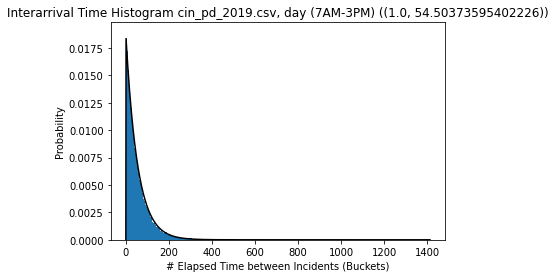

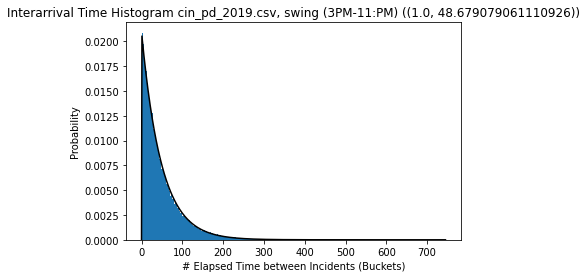

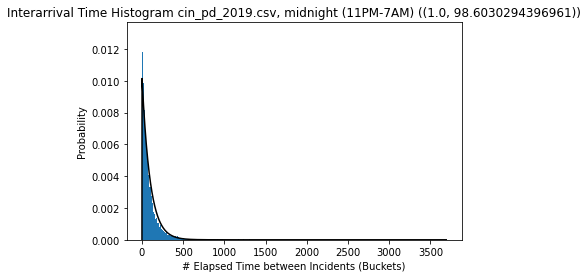

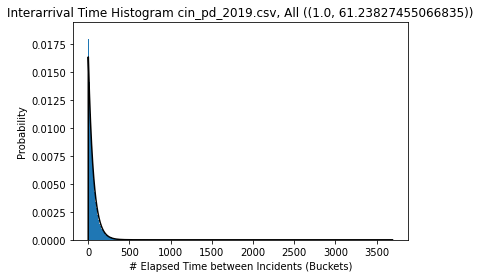

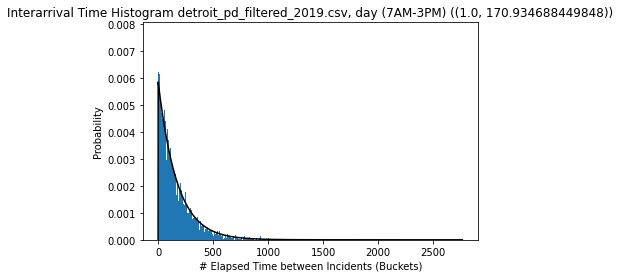

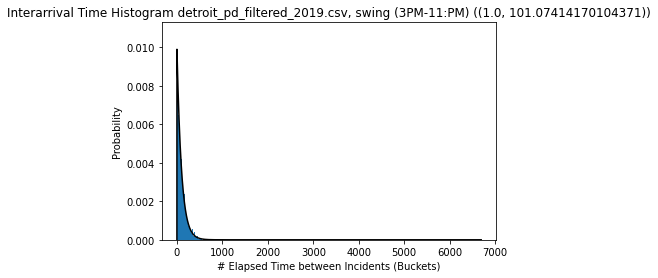

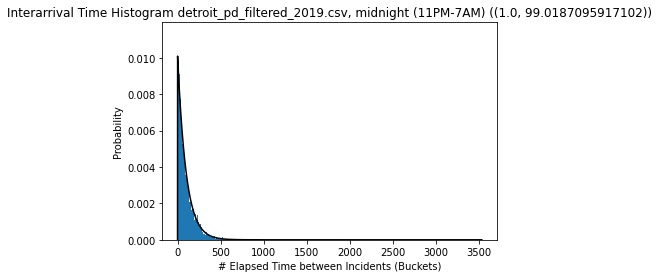

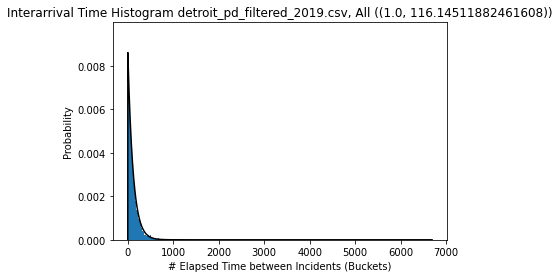

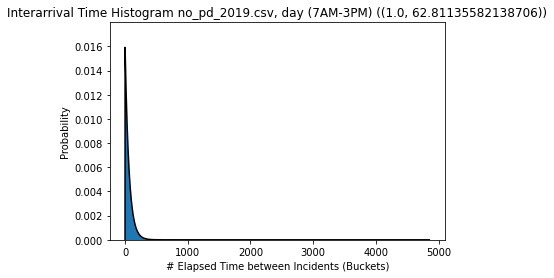

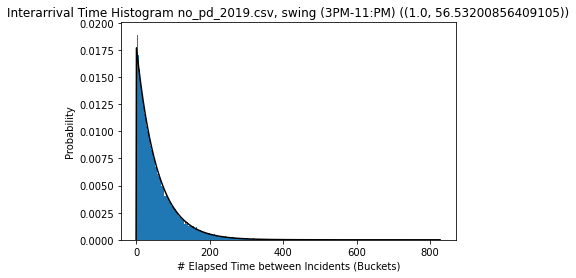

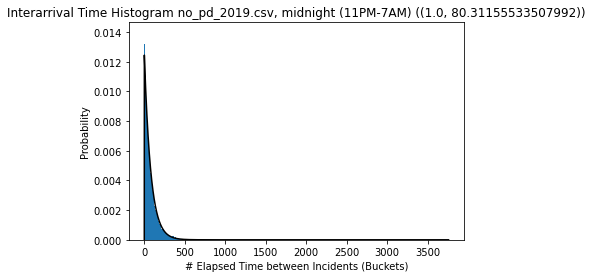

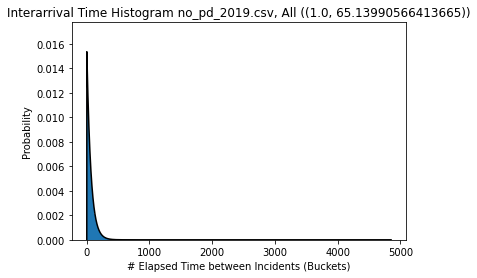

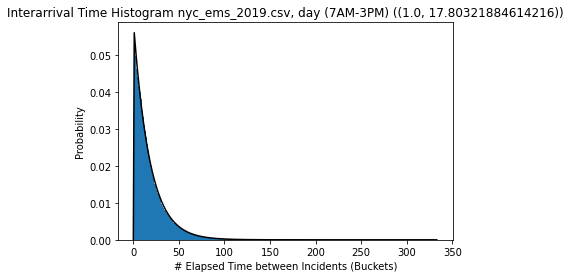

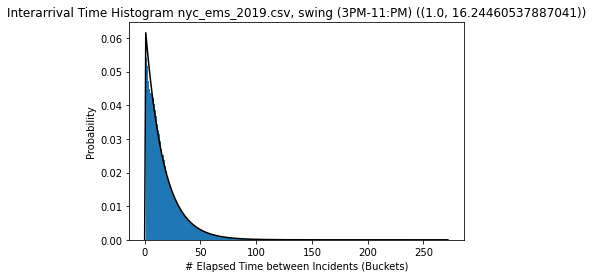

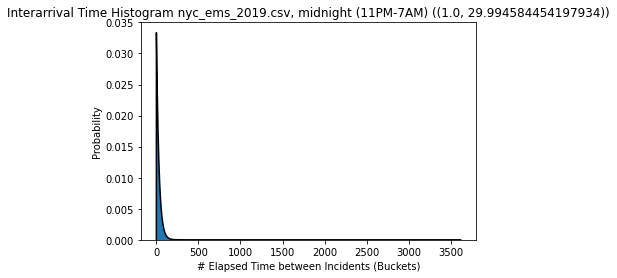

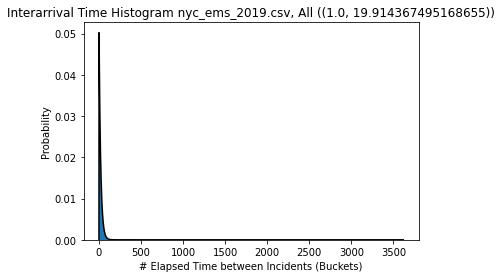

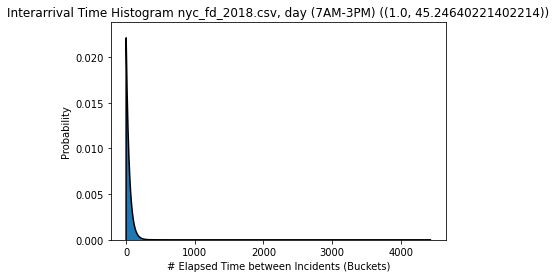

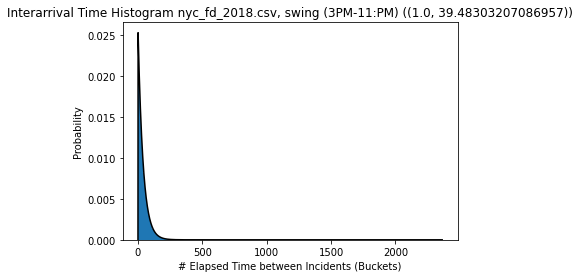

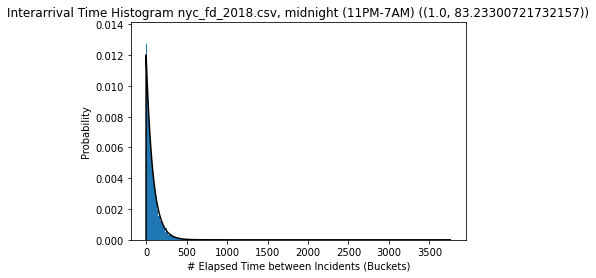

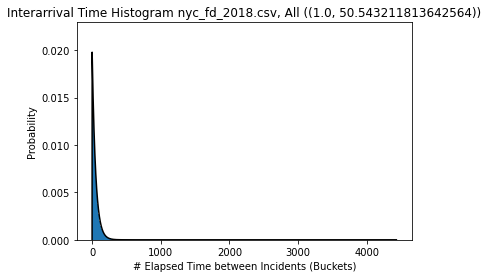

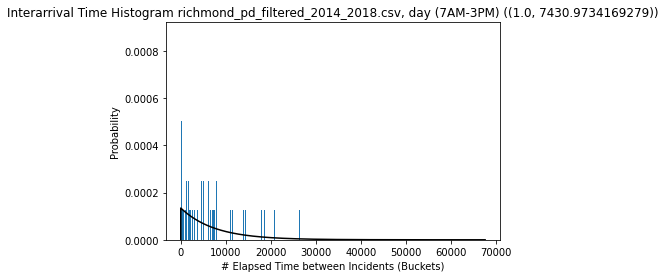

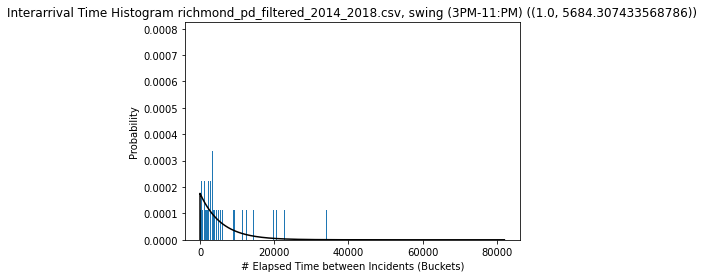

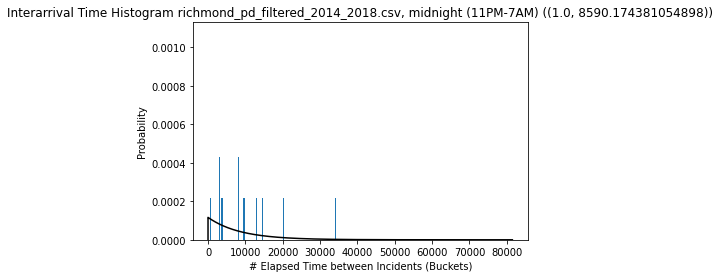

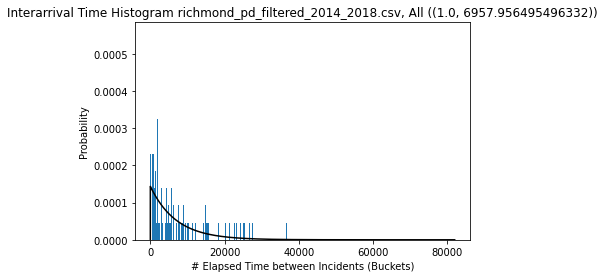

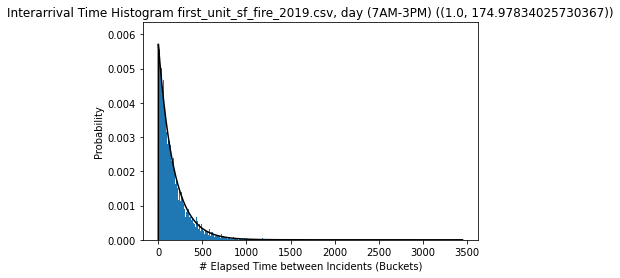

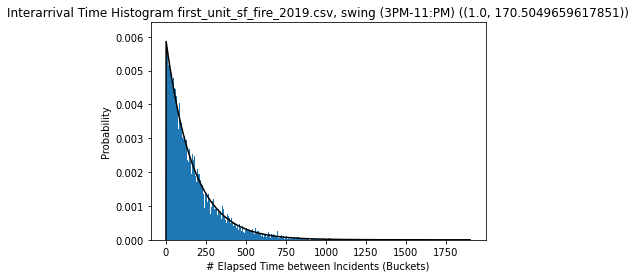

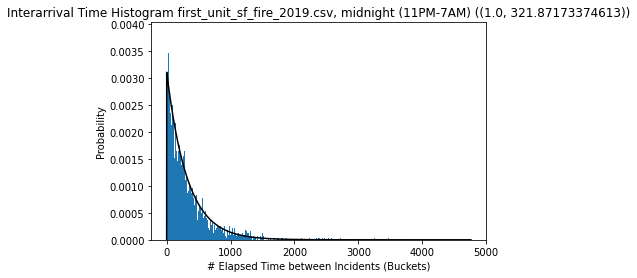

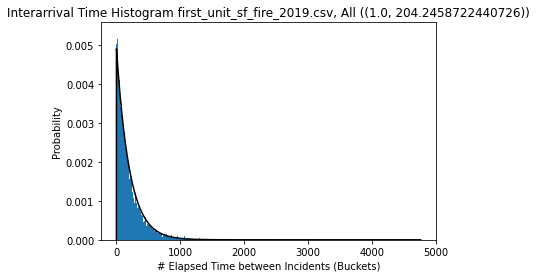

In [21]:
import matplotlib.pyplot as plt
for name, obj in inter_arrival_map.items():
    plot_interarrival_histogram(name, obj)

/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created

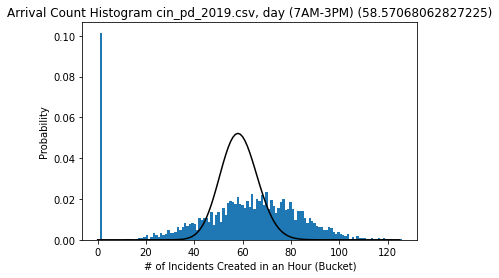

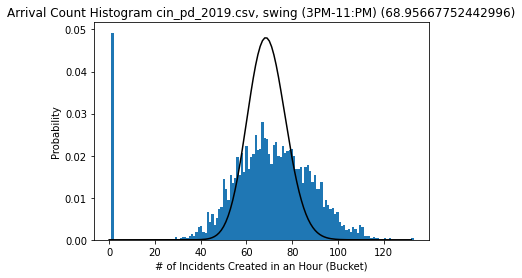

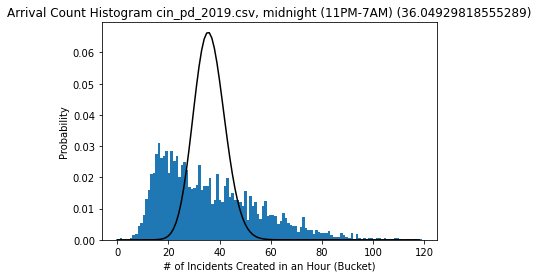

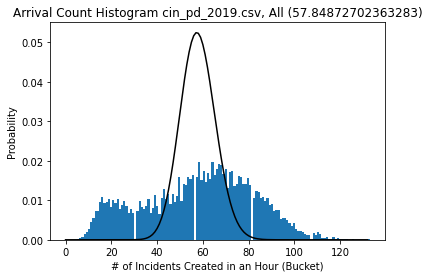

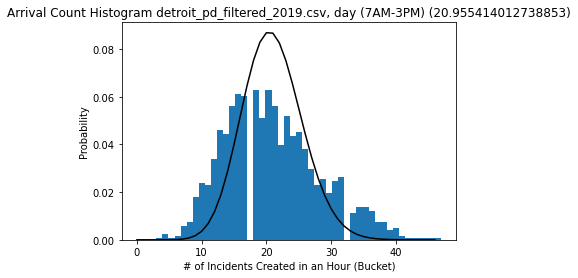

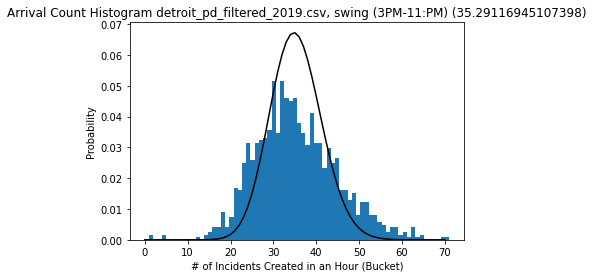

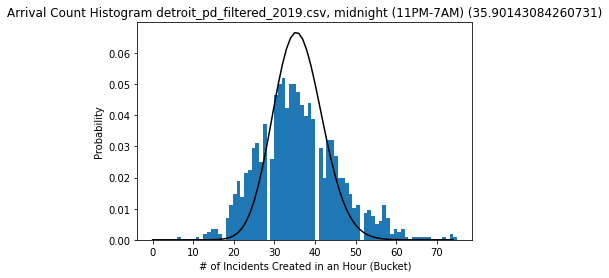

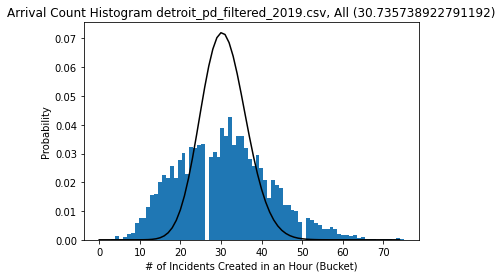

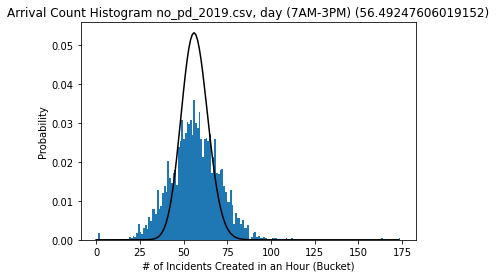

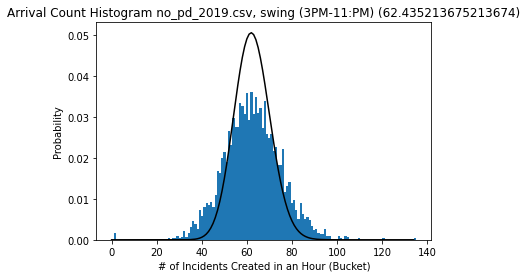

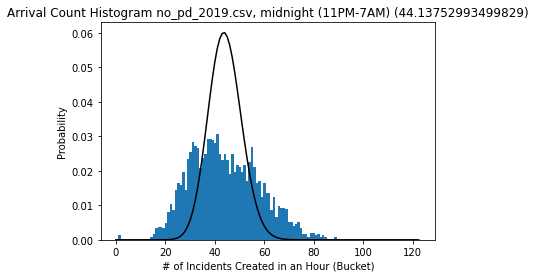

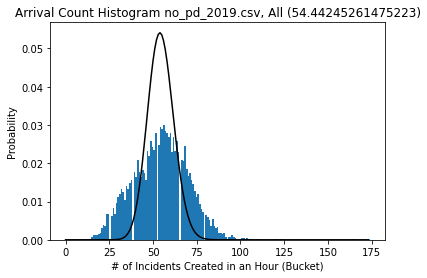

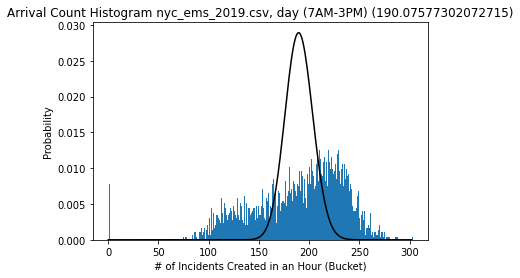

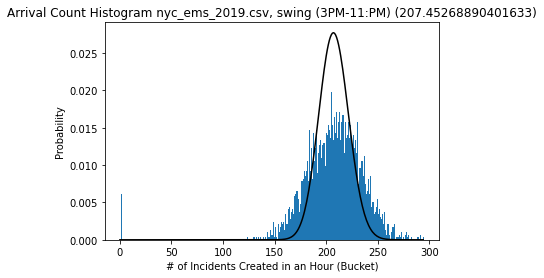

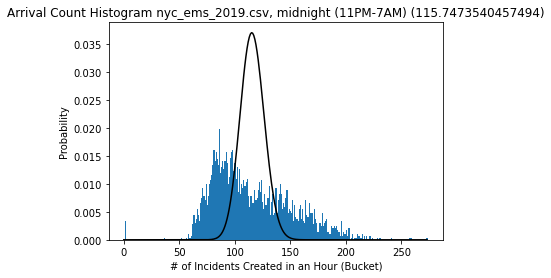

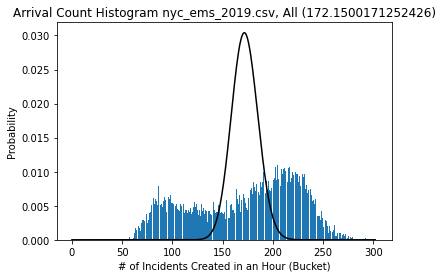

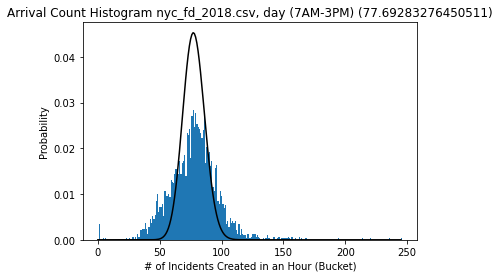

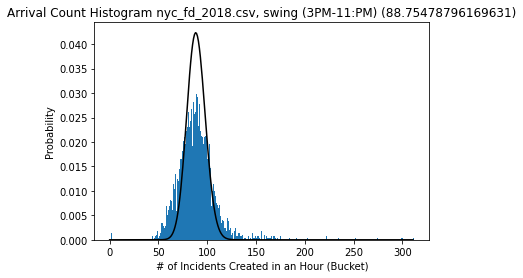

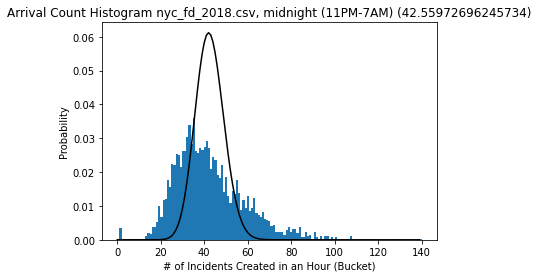

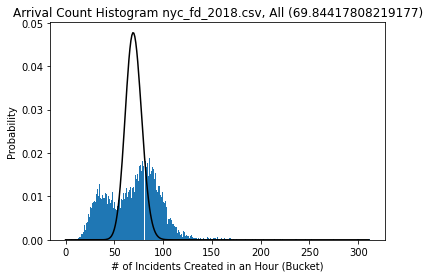

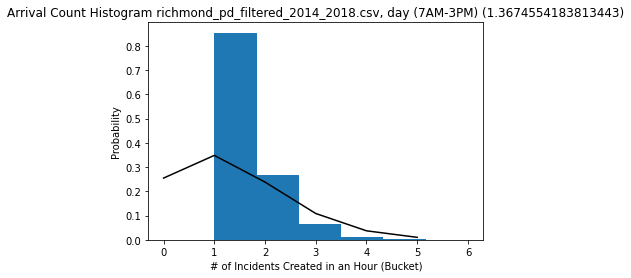

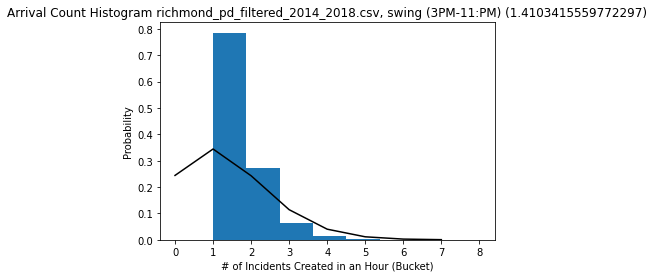

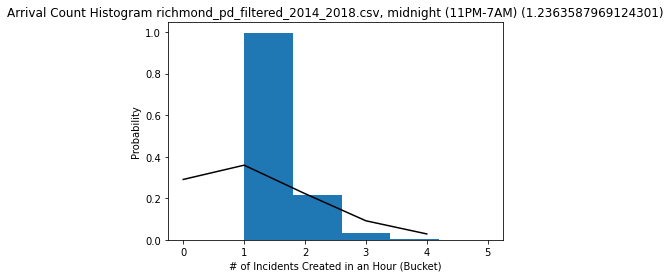

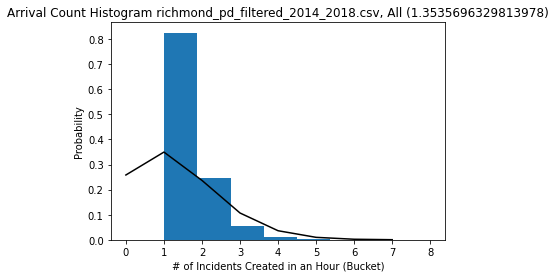

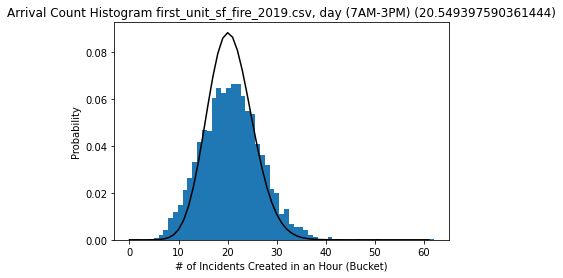

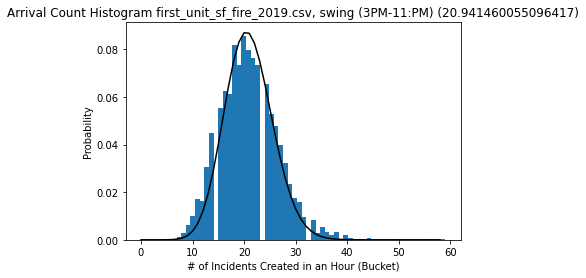

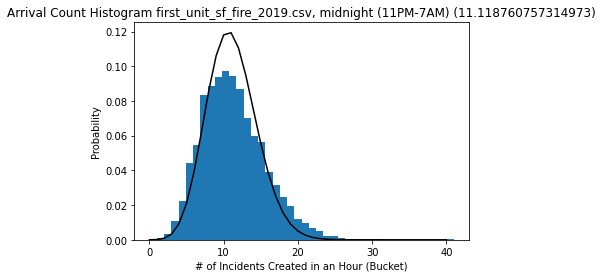

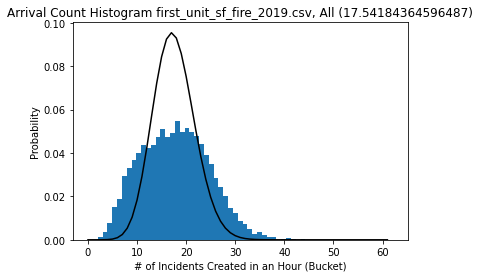

In [22]:
for name, obj in arrival_count_map.items():
    plot_arrival_histogram(name, obj)